## Ground effect for Airfoil

-- Important takeaway -- 

We can see in either case, the upper surface's cp
 does not change a lot compared with result without ground effect, however, the performance of the lower surface at different α
 diverges for very small clearances (h/c)
. For a larger angle of attack, α=10
 in this case, the flow nearly stagnates under the lower surface, creating a huge amount of lift, and some paper names this effect as "ram pressure". However, for a symmetrical airfoil NACA 0012 at zero angle of attack, the lower surface and the ground forms a "convergent-divergent" passage (de Laval nozzle). Due to the thickness of the airfoil, after the leading edge, the cross-section area of airflow is shrinking, so the air under the lower surface speeds up, giving rise to a low pressure region at the lower surface.

For any airfoil in ground effect with a very small ground clearance (h/c<0.4
 in this case), these two effects ("ram pressure" and "convergent-divergent passage") coexist. When α
 is greater, the former dominates, showing an increasing of Cl
; while if α
 is small, the latter dominates, creating a negative lift.

In [1]:
import numpy
from matplotlib import pyplot
from matplotlib import rcParams 

%matplotlib inline

#plot parameters 
rcParams['figure.dpi'] = 100
rcParams['font.family'] = 'StixGeneral'
rcParams['font.size'] = 12

airfoil_file = 'NACA4415-2.dat'

Here along one pannel - we are assuming linear distribution of vortex strength 

As usual - neuman boundary condition of gradient of potential function normal to the surface = 0 is applied - which gives 
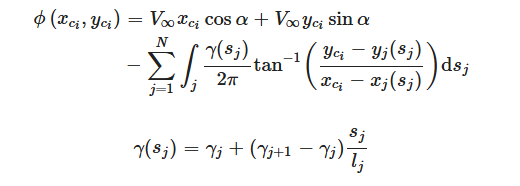  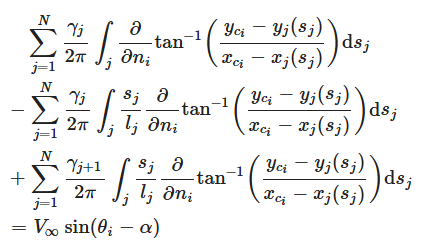

Now instead of interating this - we use analytical solution - which uses non-dimentional circulation density - gamm/(2pi*vinf)
- Combine the gamma_j terms and gamma_j+1 terms as one - give Cn1 and Cn2 - as corresponding coefficients - 

- [LINK](https://nbviewer.org/github/barbagroup/AeroPython-studentprojects2015/blob/master/Ground-Effect-in-Vortex-Panel-Method/Ground-Effect-in-Vortex-Panel-Method.ipynb)   - has the equations and sources for it

In [2]:
def evaluate_coefficient(x, y, xc, yc, theta, l):
    """
    -------
    cn1: (array of float)
         the source panel's left end vortex's contribution on target panel in normal direction
    cn2: (array of float)
         the source panel's right end vortex's contribution on target panel in normal direction     
    ct1: (array of float)
         the source panel's left end vortex's contribution on target panel in tangential direction
    ct2: (array of float)
         the source panel's right end vortex's contribution on target panel in tangential direction
    """
    # initialize the coefficient matrix
    np = len(xc)
    cn1 = numpy.zeros((np,np), dtype=float)
    cn2 = numpy.zeros((np,np), dtype=float)
    ct1 = numpy.zeros((np,np), dtype=float)
    ct2 = numpy.zeros((np,np), dtype=float)
    # fill in the matrix when i=j (singularity)
    numpy.fill_diagonal(cn1, -1.)
    numpy.fill_diagonal(cn2, 1.)
    numpy.fill_diagonal(ct1, numpy.pi/2)
    numpy.fill_diagonal(ct2, numpy.pi/2)
    # double loop in i,j to evaluate j's contribution to i's panel when i!=j
    for i in range(np):
        for j in list(list(range(i))+list(range(i+1,np))):
            A = -(xc[i]-x[j])*numpy.cos(theta[j])-(yc[i]-y[j])*numpy.sin(theta[j])
            B = (xc[i]-x[j])**2+(yc[i]-y[j])**2
            C = numpy.sin(theta[i]-theta[j])
            D = numpy.cos(theta[i]-theta[j])
            E = (xc[i]-x[j])*numpy.sin(theta[j])-(yc[i]-y[j])*numpy.cos(theta[j])
            F = numpy.log(1+(l[j]**2+2*A*l[j])/B)
            G = numpy.arctan2((E*l[j]),(B+A*l[j]))
            P = (xc[i]-x[j])*numpy.sin(theta[i]-2*theta[j])+(yc[i]-y[j])*numpy.cos(theta[i]-2*theta[j])
            Q = (xc[i]-x[j])*numpy.cos(theta[i]-2*theta[j])-(yc[i]-y[j])*numpy.sin(theta[i]-2*theta[j])
            cn2[i,j]=D+0.5*Q*F/l[j]-(A*C+D*E)*G/l[j]
            cn1[i,j]=0.5*D*F+C*G-cn2[i,j]
            ct2[i,j]=C+0.5*P*F/l[j]+(A*D-C*E)*G/l[j]
            ct1[i,j]=0.5*C*F-D*G-ct2[i,j]
    return cn1, cn2, ct1, ct2 

In [3]:
def build_A(cn1, cn2, ct1, ct2):
    """Build the coefficient matrix of the linear system based on the panel-panel coefficient matrix
    
    Parameters:
    ----------
    cn1, cn2, ct1, ct2: see docstring in function 'evaluate_coefficient'
    
    Returns:
    -------
    an: (array of float)
        the coefficient matrix in normal direction, including the kutta-condition in the last row
    at: (array of float)
        the coefficient matrix in tangential direction
    """
    # initialize the coefficient matrix for normal and tangential directions
    np = cn1.shape[0]
    an = numpy.zeros((np+1,np+1),dtype=float)
    at = numpy.zeros((np,np+1),dtype=float)
    # loop in every element in the coefficient matrix
    for i in range(np):
        # fill the first column (0th-panel's first end's effect on ith-panel)
        # and the last column (-1th-panel's second end's effect on ith-panel)
        an[i,0] = cn1[i,0]
        an[i,-1] = cn2[i,-1]
        at[i,0] = ct1[i,0]
        at[i,-1] = ct2[i,-1]
        # each element in the middle are influenced by two panels
        # j-th panel's first end and (j-1)th panel's right end
        for j in range(1,np):
            an[i,j] = cn1[i,j] + cn2[i,j-1]
            at[i,j] = ct1[i,j] + ct2[i,j-1]
    # kutta condition
    an[-1,0] = 1.
    an[-1,-1] = 1.
    return an, at

In [4]:
def vortex_panel_method(filename, alpha):
    """Given the filename of panel coordinates file, and the angle of attack, return the control points, its pressure coefficient and total lift.
    
    Parameters:
    ----------
    filename: (string)
              Panel's coordinates input file
    alpha: (float)
            angle of attack in degree
    
    Returns:
    -------
    xc: (array of float)
        array of control points' x coordinates
    cp: (array of float)
        array of pressure coefficient at the control points
    cl: (float)
        the lift coefficient of the airfoil
           
    """
    # load airfoil data
    x, y = numpy.loadtxt(filename, delimiter=' ', unpack=True)
    
    # calculate the geometry parameters of panels
    xc = 0.5*(x[1:] + x[:-1])    # x of panel's center
    yc = 0.5*(y[1:] + y[:-1])    # y of panel's center
    np = len(xc)    # number of panels
    l = numpy.sqrt((x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2)    # panel's length
    theta = numpy.arctan2(y[1:]-y[:-1],x[1:]-x[:-1])    # panel's angle with horizontal axis
    
    # evaluate the panel-to-panel coefficient 
    cn1, cn2, ct1, ct2 = evaluate_coefficient(x, y, xc, yc, theta, l)
    
    # evaluate the coefficient matrix A (related to gammas)
    an, at = build_A(cn1, cn2, ct1, ct2)
    
    # calculate the rhs
    b = numpy.sin(theta-alpha/180.*numpy.pi)    # freestream's contribution
    b = numpy.append(b, 0.)    # add kutta condition
    
    # solve the linear system
    gamma = numpy.linalg.solve(an, b)
    
    # evaluate the tangential velocity and pressure coefficient at control points
    vt = numpy.dot(at, gamma) + numpy.cos(theta-alpha/180.*numpy.pi)
    cp = 1 - vt**2
    
    # evaluate the lift
    cl = -numpy.dot(cp, l*numpy.cos(theta-alpha/180.*numpy.pi))
    
    return xc, cp, cl

In [5]:
input_file =  airfoil_file  #'NACA4415edit.txt'
output_file = 'NACA4415edit_clean.txt'

with open(input_file, 'r') as infile:
    lines = infile.readlines()

# Reverse and clean each line
lines = [' '.join(line.strip().split()) for line in lines[::-1]]

with open(output_file, 'w') as outfile:
    for line in lines:
        outfile.write(line + '\n')

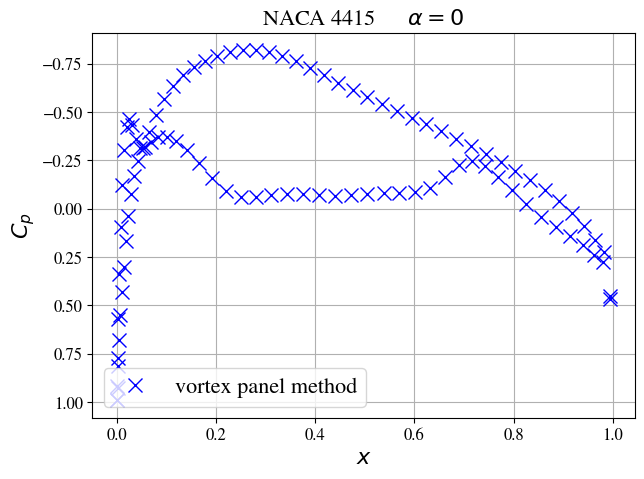

In [19]:
xc_0, cp_0, cl_0 = vortex_panel_method(output_file, 0.0) #NACA0012_N=100  NACA4415edit

pyplot.figure(figsize=(7,5))
l1, = pyplot.plot(xc_0, cp_0, 'bx', markersize=10, label='vortex panel method')

pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.legend(handles=[l1], loc=3, fontsize=16)
pyplot.grid('on')
pyplot.title(r'NACA 4415 $\quad$ $\alpha = 0$', fontsize=16)
pyplot.gca().invert_yaxis();

xc_10, cp_10, cl_10 = vortex_panel_method(output_file, 10.0) #NACA0012_N=100  NACA4415edit

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


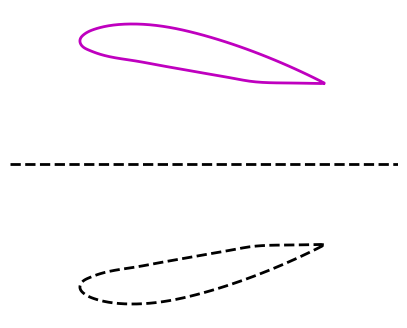

In [7]:
x, y = numpy.loadtxt(output_file, delimiter=' ', unpack=True)
h, alpha = 0.5, 10.0

## making the mirror airfoil 
x_rot = x*numpy.cos(alpha/180.*numpy.pi) + y*numpy.sin(alpha/180.*numpy.pi)
y_rot = -x*numpy.sin(alpha/180.*numpy.pi) + y*numpy.cos(alpha/180.*numpy.pi) + h
x, y = x_rot, y_rot
x_i, y_i = x_rot, -y_rot

pyplot.figure(figsize=(5,4), frameon=False)
pyplot.plot(x,y, 'm-', linewidth=2)
pyplot.plot(x_i, y_i, 'k--', linewidth=2)
pyplot.axis('equal')
pyplot.axis('off')
pyplot.xlim(-0.5,1.5)
pyplot.axhline(0., color='k', linestyle='--', linewidth=2);



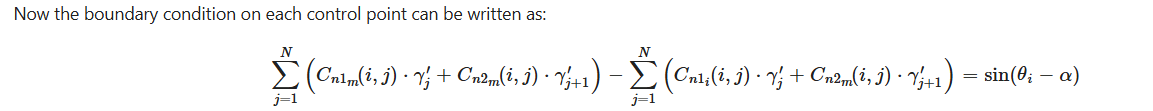

In [8]:
def evaluate_coefficient_image(x_i, y_i, xc, yc, theta,theta_i, l):
    """Given the end points' coordinates (x,y), angles(theta), panel length (l) of target panels, evaluate their contributions
      to source panels with control points (xc, yc), and return the panel-panel coefficient matrix in normal and tangential direction,
        and for the left end and right end respectively.
    
    Parameters:
    ----------
    x_i, y_i: (array of float)
          x,y coordinates of image panels' end points
    xc, yc: (array of float)
            x,y coordinates of control points on main airfoil panels
    theta_i: (array of float)
            array of angles between x-axis and image panels
    l: (array of float)
        array of image panels' length
        
    Returns:
    -------
    cn1_i: (array of float)
           the source image panel's left end vortex's contribution on target panel in normal direction
    cn2_i: (array of float)
           the source image panel's right end vortex's contribution on target panel in normal direction     
    ct1_i: (array of float)
           the source image panel's left end vortex's contribution on target panel in tangential direction
    ct2_i: (array of float)
           the source image panel's right end vortex's contribution on target panel in tangential direction
    """
    np = len(xc)
    cn1_i = numpy.zeros((np,np), dtype=float)
    cn2_i = numpy.zeros((np,np), dtype=float)
    ct1_i = numpy.zeros((np,np), dtype=float)
    ct2_i = numpy.zeros((np,np), dtype=float)
    for i in range(np):
        for j in range(np):
            A = -(xc[i]-x_i[j])*numpy.cos(theta_i[j])-(yc[i]-y_i[j])*numpy.sin(theta_i[j])
            B = (xc[i]-x_i[j])**2+(yc[i]-y_i[j])**2
            C = numpy.sin(theta[i]-theta_i[j])
            D = numpy.cos(theta[i]-theta_i[j])
            E = (xc[i]-x_i[j])*numpy.sin(theta_i[j])-(yc[i]-y_i[j])*numpy.cos(theta_i[j])
            F = numpy.log(1+(l[j]**2+2*A*l[j])/B)
            G = numpy.arctan2((E*l[j]),(B+A*l[j]))
            P = (xc[i]-x_i[j])*numpy.sin(theta[i]-2*theta_i[j])+(yc[i]-y_i[j])*numpy.cos(theta[i]-2*theta_i[j])
            Q = (xc[i]-x_i[j])*numpy.cos(theta[i]-2*theta_i[j])-(yc[i]-y_i[j])*numpy.sin(theta[i]-2*theta_i[j])
            cn2_i[i,j]=D+0.5*Q*F/l[j]-(A*C+D*E)*G/l[j]
            cn1_i[i,j]=0.5*D*F+C*G-cn2_i[i,j]
            ct2_i[i,j]=C+0.5*P*F/l[j]+(A*D-C*E)*G/l[j]
            ct1_i[i,j]=0.5*C*F-D*G-ct2_i[i,j]
    return cn1_i, cn2_i, ct1_i, ct2_i

In [9]:
def ground_effect(filename, alpha, h):
    """Given the filename of panel coordinates file, and the angle of attack, and the height of the leading edge above the ground, return the control points, its pressure coefficient and total lift.
    
    Parameters:
    ----------
    filename: (string)
              Panel's coordinates input file
    alpha: (float)
            angle of attack in degree
    h: (float)
        the height of the leading edge above the ground
    
    Returns:
    -------
    xc: (array of float)
        array of control points' x coordinates
    cp: (array of float)
        array of pressure coefficient at the control points
    cl: (float)
        the lift coefficient of the airfoil under ground effect
           
    """
    # load airfoil data
    x, y = numpy.loadtxt(filename, delimiter=' ', unpack=True)
    
    # rotate the coordinates
    x_rot = x*numpy.cos(alpha/180.*numpy.pi) + y*numpy.sin(alpha/180.*numpy.pi)
    y_rot = -x*numpy.sin(alpha/180.*numpy.pi) + y*numpy.cos(alpha/180.*numpy.pi) + h
    x, y = x_rot, y_rot
    x_i, y_i = x_rot, -y_rot
    
    # calculate the geometry parameters of panels
    xc = 0.5*(x[1:] + x[:-1])    # x of panel's center
    yc = 0.5*(y[1:] + y[:-1])    # y of panel's center
    np = len(xc)    # number of panels
    l = numpy.sqrt((x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2)    # panel's length
    theta = numpy.arctan2(y[1:]-y[:-1],x[1:]-x[:-1])    # panel's angle with horizontal axis
    theta_i = -theta
    
    # evaluate the panel-to-panel coefficient
    cn1_m, cn2_m, ct1_m, ct2_m = evaluate_coefficient(x, y, xc, yc, theta, l)
    cn1_i, cn2_i, ct1_i, ct2_i = evaluate_coefficient_image(x_i, y_i, xc, yc,theta, theta_i, l)
    cn1, cn2, ct1, ct2 = cn1_m-cn1_i, cn2_m-cn2_i, ct1_m-ct1_i, ct2_m-ct2_i
    
    # evaluate the coefficient matrix A (related to gammas)
    an, at = build_A(cn1, cn2, ct1, ct2)
    
    # calculate the rhs (alpha is included in panel's geometry)
    b = numpy.sin(theta)    # freestream's contribution
    b = numpy.append(b, 0.)    # add kutta condition
    
    # solve the linear system
    gamma = numpy.linalg.solve(an, b)
    
    # evaluate the tangential velocity and pressure coefficient at control points
    vt = numpy.dot(at, gamma) + numpy.cos(theta)
    cp = 1 - vt**2
    
    # evaluate the lift
    cl = -numpy.dot(cp, l*numpy.cos(theta))
    
    return np,xc, cp, cl

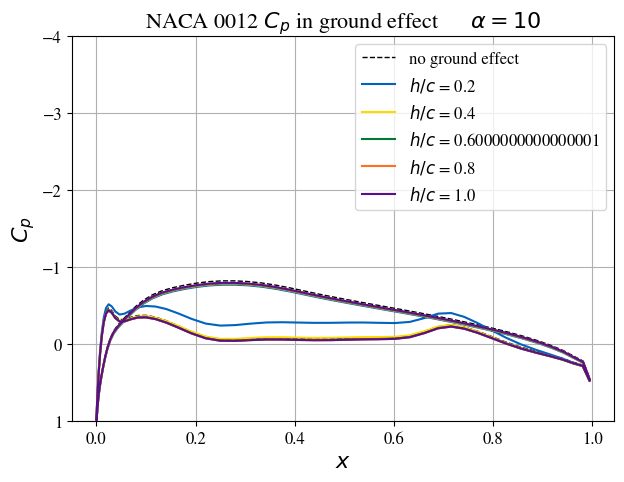

In [14]:
# run ground effect in a series of different height
alpha = 0
n_set = 5
h_set = numpy.linspace(0.2, 1, n_set)
xc_set, cp_set, cl_set = [None]*n_set, [None]*n_set, [None]*n_set
for i,h in enumerate(h_set):
    np,xc_set[i], cp_set[i], cl_set[i] = ground_effect(output_file, alpha, h)

rcParams['font.size'] = 12
colors = ["#0063be","#fed900","#007836","#ff6f20","#580f8b"]
# plot the cp distribution and compare with source vortex panel solution
pyplot.figure(figsize=(7,5))
pyplot.plot(xc_0, cp_0, 'k--', linewidth=1, label='no ground effect')
for i,h in enumerate(h_set):
    pyplot.plot(xc_set[i], cp_set[i], color=colors[i], linewidth=1.5, label='$h/c$ = '+str(h))
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.legend(loc=1)
pyplot.grid('on')
pyplot.title(r'NACA 0012 $C_p$ in ground effect $\quad$ $\alpha = 10$', fontsize=16)
pyplot.ylim(-4, 1)
pyplot.gca().invert_yaxis();

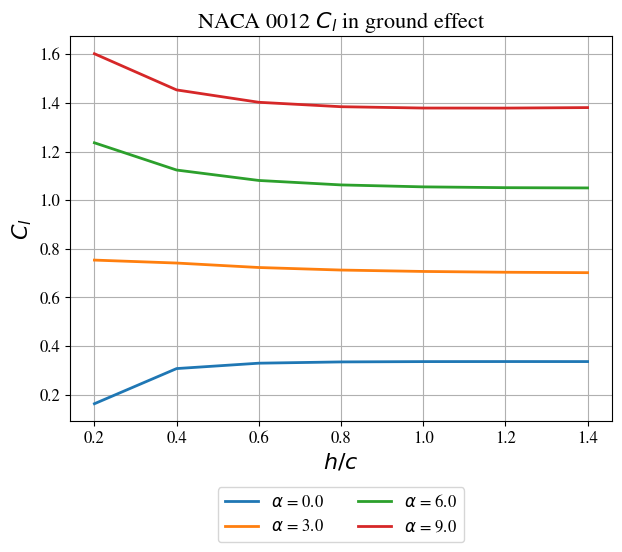

In [15]:
alpha_set = numpy.linspace(0., 9., 4)
h_set = numpy.linspace(0.2, 1.4, 7)
cl_set = numpy.zeros(len(h_set), dtype=float)
pyplot.figure(figsize=(7,5))
for i, alpha in enumerate(alpha_set):
    for j, h in enumerate(h_set):
        cl_set[j] = ground_effect(output_file, alpha, h)[-1]    
    pyplot.plot(h_set, cl_set, label=r'$\alpha$ = '+str(alpha), linewidth=2)
pyplot.xlabel('$h/c$', fontsize=16)
pyplot.ylabel('$C_l$', fontsize=16)
pyplot.title(r'NACA 0012 $C_l$ in ground effect', fontsize=16)
pyplot.grid('on')
pyplot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, ncol=2)
pyplot.show();

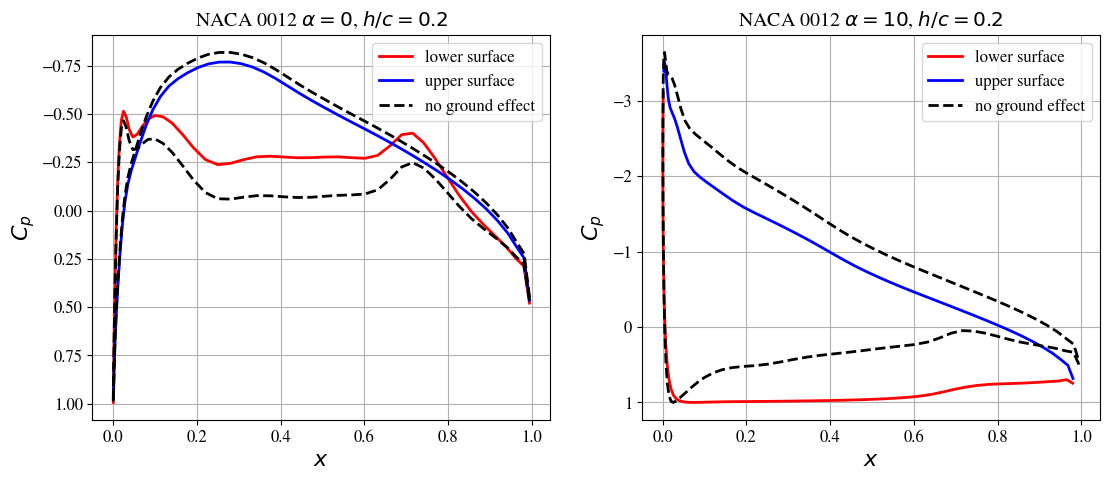

In [20]:
n, x_1, cp_1, cl_1 = ground_effect(output_file, 0.0, 0.2)
n, x_2, cp_2, cl_2 = ground_effect(output_file, 10.0, 0.2)

n = 100
pyplot.figure(figsize=(13,5))
pyplot.subplot(1,2,1)
pyplot.plot(x_1[:n//2], cp_1[:n//2], 'r-', linewidth=2, label='lower surface')
pyplot.plot(x_1[n//2:], cp_1[n//2:], 'b-', linewidth=2, label='upper surface')
pyplot.plot(xc_0, cp_0, 'k--', linewidth=2, label='no ground effect')
pyplot.legend(loc='best')
pyplot.grid('on')
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.xlabel('$x$', fontsize=16)
pyplot.title(r'NACA 0012 $\alpha = 0$, $h/c = 0.2$')
pyplot.gca().invert_yaxis()
pyplot.subplot(1,2,2)
pyplot.plot(x_2[:n//2], cp_2[:n//2], 'r-', linewidth=2, label='lower surface')
pyplot.plot(x_2[n//2:], cp_2[n//2:], 'b-', linewidth=2, label='upper surface')
pyplot.plot(xc_10, cp_10, 'k--', linewidth=2, label='no ground effect')
pyplot.legend(loc='best')
pyplot.grid('on')
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.xlabel('$x$', fontsize=16)
pyplot.title(r'NACA 0012 $\alpha = 10$, $h/c = 0.2$')
pyplot.gca().invert_yaxis();

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


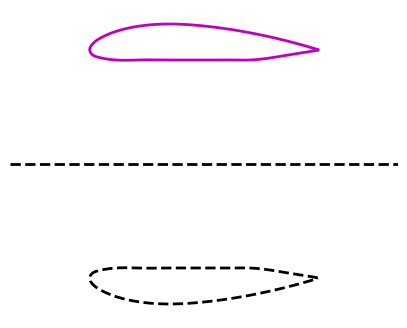

In [21]:
x, y = numpy.loadtxt(output_file, delimiter=' ', unpack=True)

h, alpha = 0.5, 0.0
x_rot = x*numpy.cos(alpha/180.*numpy.pi) + y*numpy.sin(alpha/180.*numpy.pi)
y_rot = -x*numpy.sin(alpha/180.*numpy.pi) + y*numpy.cos(alpha/180.*numpy.pi) + h
x, y = x_rot, y_rot
x_i, y_i = x_rot, -y_rot

pyplot.figure(figsize=(5,4), frameon=False)
pyplot.plot(x,y, 'm-', linewidth=2)
pyplot.plot(x_i, y_i, 'k--', linewidth=2)
pyplot.axis('equal')
pyplot.axis('off')
pyplot.xlim(-0.5,1.5)
pyplot.axhline(0., color='k', linestyle='--', linewidth=2);

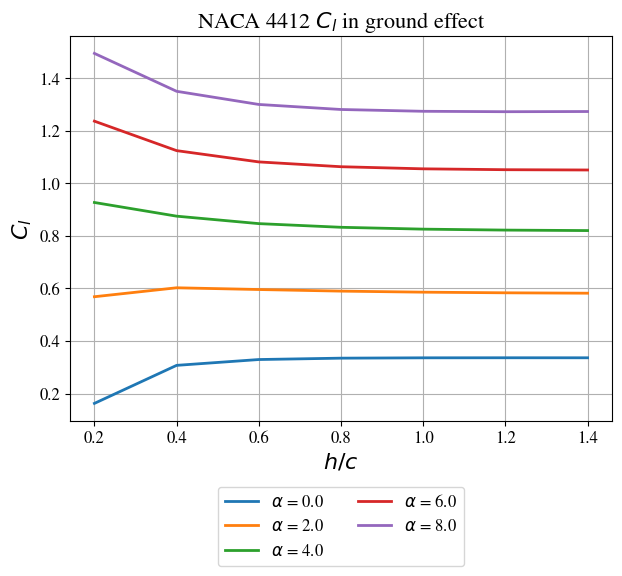

In [22]:
alpha_set = numpy.linspace(0., 8., 5)
h_set = numpy.linspace(0.2, 1.4, 7)
cl_set = numpy.zeros(len(h_set), dtype=float)
pyplot.figure(figsize=(7,5))
for i, alpha in enumerate(alpha_set):
    for j, h in enumerate(h_set):
        cl_set[j] = ground_effect(output_file, alpha, h)[-1]    
    pyplot.plot(h_set, cl_set, label=r'$\alpha$ = '+str(alpha), linewidth=2)
pyplot.xlabel('$h/c$', fontsize=16)
pyplot.ylabel('$C_l$', fontsize=16)
pyplot.title('NACA 4412 $C_l$ in ground effect', fontsize=16)
pyplot.grid('on')
pyplot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, ncol=2);

In [23]:
import numpy as np
from scipy.special import ellipk, ellipe
from scipy.integrate import quad

# Load aerofoil geometry from file
aerofoil = np.loadtxt('aerofoil.dat')

# Define conformal mapping parameters
a = 1.0  # Aerofoil chord length
h = 0.5  # Ground clearance

# Flat Plate Map
def flat_plate_map(z):
    return z + a**2 / (4*z) - 1j*h

# Solve potential flow in annulus domain
def potential_flow(z, circulation, alpha):
    # Compute Schottky-Klein prime function
    q = np.exp(-np.pi*h/a)
    P = lambda zeta: 1.0
    for n in range(1, 100):
        P += (-1)**n * q**(n*(n-1)) * (zeta**n - q**(2*n)*zeta**(-n))
    P *= (1 - q**2)**2 / (np.pi * (1 - q))

    # Compute complex potential
    w = circulation / (2*np.pi) * np.log(P(np.exp(1j*alpha))/P(z)) + 1j*circulation*np.sin(alpha)*(z - a**2/(4*z))
    return w.real, w.imag

# Example usage
alpha = np.deg2rad(5)  # Angle of attack
circulation = 1.0      # Circulation
z = flat_plate_map(aerofoil[:,0] + 1j*aerofoil[:,1])
phi, psi = potential_flow(z, circulation, alpha)

# Plot results
import matplotlib.pyplot as plt
plt.figure()
plt.plot(aerofoil[:,0], aerofoil[:,1])
plt.plot(np.real(z), np.imag(z))
plt.streamplot(np.real(z), np.imag(z), phi, psi)
plt.show()

FileNotFoundError: aerofoil.dat not found.